In [1]:
import numpy as np
import os
from oe_acute import trial_utils as tu
from oe_acute import MNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import tqdm
import glob

import sys
from oe_acute import pyMNE

In [2]:
os.nice(1)

1

### Load dsets

In [3]:
stim_sp = np.load('/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_32/enc_test_32.npy')
stim_pred = np.load('/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_32/pred_test_32.npy')
stim_y = np.load('/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_32/y_test_32.npy')
stim_resp = np.load('/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_32/resp_test_32.npy')

In [4]:
stim_err = stim_y - stim_pred
stim_spec = np.concatenate((stim_sp, stim_err), axis=1)

In [5]:
np.shape(stim_spec), np.shape(stim_resp)

((5706, 64), (5706, 214, 32))

In [6]:
def prepare_MNE_dset(stim_spec, stim_resp, nsegbins=32, concat=True):
    '''
    Create the dataset for fitting MNE model
    '''
    stim_mne = []
    resp_mne = []
    for s, r in zip(stim_spec, stim_resp):
        #nfreq, ntime = s.shape
        #s_segs = np.stack([s[:, n:(n+nsegbins)] for n in range(ntime - nsegbins)], axis=0)
        s_segs = s
        r_segs = np.sum(r, axis=1)
        stim_mne.append(s_segs)
        resp_mne.append(r_segs)
    if concat:
        return np.vstack(stim_mne), np.vstack(resp_mne)
    else:
        return stim_mne, resp_mne

In [7]:
nsegbins = 32

In [8]:
stim_mne = []
resp_mne = []
stim_mne, resp_mne = prepare_MNE_dset(stim_spec, stim_resp, nsegbins=nsegbins)

In [9]:
np.shape(stim_mne), np.shape(resp_mne)

((5706, 64), (5706, 214))

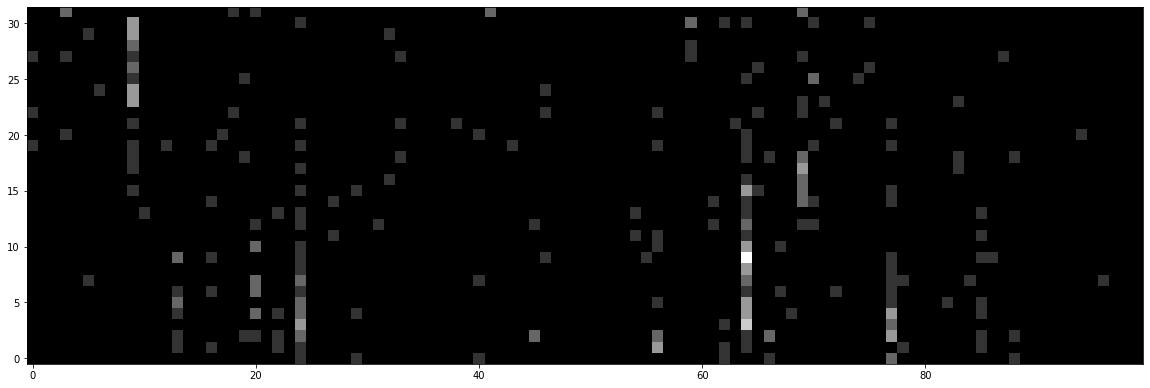

In [10]:
ax = plt.subplots(figsize=(20,8))
plt.imshow(np.transpose(stim_resp[:100, 20, :]), origin='lower', cmap='gray')

### Split into train test sets

In [11]:
len_units = np.shape(resp_mne)[1]

In [12]:
units_to_process = list(np.load('/mnt/cube/srrudrar/temporal_model/units_to_process.npy'))

In [13]:
exp_path = '/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_32/error_mne/'

In [14]:
# obtain all preprocessed datas

%matplotlib inline
sdim = 32
n_jackknives = 4

test_output_path = os.path.join(exp_path, 'MNE_test_dset')
os.makedirs(test_output_path, exist_ok=True)
n_eigvec_to_display = 6 # Number of most positive and most negative eigenvectors to display

pfinals = {}
for unit in units_to_process:
    i = units_to_process.index(unit)
    stims_train, resps_train, stims_test, resps_test = MNE.prepare_MNE_train_test_set(stim_mne, resp_mne[:,i][:,np.newaxis], train_pct=0.8, zscore=True, kz_norm_resp=True)
    
    # Save test dataset
    test_dict = {'stims_test':stims_test, 'resps_test':resps_test}
    out_fname = 'unit-{}_MNE.pkl'.format(unit)
    out_f = os.path.join(test_output_path, out_fname)
    with open(out_f, 'wb') as f:
        pickle.dump(test_dict, f)

    # Run MNE
    pfinal = MNE.fit_MNE(stims_train, resps_train, order=2)
    #MNE.plot_MNE(pfinal, unit, figure_output_path)
    pfinals[unit] = pfinal

Iters   tally   ll(test) 
    1       0    0.163995
    2       0    0.164218
    3       0    0.164375
    4       1    0.170332
    5       2    0.165979
    6       3    0.166104
    7       4    0.164321
    8       5    0.163029
    9       0    0.163658
   10       1    0.163940
   11       2    0.164677
   12       3    0.167407
   13       4    0.169174
   14       5    0.168152
   15       6    0.166807
   16       7    0.166330
   17       8    0.166221
   18       9    0.165900
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.151739
    2       0    0.151855
    3       0    0.151556
    4       0    0.148294
    5       0    0.149350
    6       1    0.147342
    7       0    0.147982
    8       1    0.148898
    9       2    0.148246
   10       3    0.146234
   11       0    0.145562
   12       0    0.145258
   13       0    0.145904
   14       1    0.148344
   15       2    0.148807
   16       3    0.148140
   17       4    0.147338
   18       

    1       0    0.096163
    2       0    0.095908
    3       0    0.095431
    4       0    0.095438
    5       1    0.094439
    6       0    0.094663
    7       1    0.094898
    8       2    0.095098
    9       3    0.095206
   10       4    0.094500
   11       5    0.094577
   12       6    0.094938
   13       7    0.094907
   14       8    0.094766
   15       9    0.094886
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.105527
    2       0    0.104390
    3       0    0.102967
    4       0    0.102870
    5       0    0.102117
    6       0    0.101467
    7       0    0.101247
    8       0    0.101472
    9       1    0.101723
   10       2    0.102297
   11       3    0.101930
   12       4    0.102041
   13       5    0.102203
   14       6    0.102862
   15       7    0.102889
   16       8    0.103223
   17       9    0.103677
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.198009
    2       0    0.196588
    3       

    1       0    0.124217
    2       0    0.124199
    3       0    0.123614
    4       0    0.123167
    5       0    0.125950
    6       1    0.127333
    7       2    0.127621
    8       3    0.127359
    9       4    0.126781
   10       5    0.126222
   11       6    0.125496
   12       7    0.125378
   13       8    0.125152
   14       9    0.125184
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.123337
    2       0    0.123342
    3       0    0.122347
    4       0    0.126409
    5       1    0.127307
    6       2    0.124964
    7       3    0.124867
    8       4    0.123205
    9       5    0.122729
   10       6    0.122211
   11       0    0.122912
   12       1    0.123239
   13       2    0.123126
   14       3    0.122886
   15       4    0.123808
   16       5    0.124185
   17       6    0.123734
   18       7    0.124017
   19       8    0.125130
   20       9    0.125283
minimum of test set found
Iters   tally   ll(test) 
    1       

    6       1    0.300877
    7       2    0.301728
    8       3    0.302078
    9       4    0.301037
   10       5    0.300558
   11       6    0.300134
   12       7    0.299976
   13       8    0.299992
   14       9    0.298696
   15       0    0.298811
   16       1    0.298855
   17       2    0.298320
   18       0    0.298598
   19       1    0.300657
   20       2    0.301254
   21       3    0.300849
   22       4    0.301100
   23       5    0.301395
   24       6    0.301146
   25       7    0.301221
   26       8    0.301525
   27       9    0.301625
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.115037
    2       0    0.115405
    3       0    0.114856
    4       0    0.113704
    5       0    0.114031
    6       1    0.113157
    7       0    0.112614
    8       0    0.112226
    9       0    0.112112
   10       0    0.112952
   11       1    0.112330
   12       2    0.112355
   13       3    0.112491
   14       4    0.112831
   15       

    1       0    0.619655
    2       0    0.619137
    3       0    0.617692
    4       0    0.618779
    5       1    0.619220
    6       2    0.618006
    7       3    0.618807
    8       4    0.618076
    9       5    0.617131
   10       0    0.616741
   11       0    0.617200
   12       1    0.617058
   13       2    0.616617
   14       0    0.616568
   15       0    0.617111
   16       1    0.617522
   17       2    0.616694
   18       3    0.616945
   19       4    0.618137
   20       5    0.617898
   21       6    0.618947
   22       7    0.619722
   23       8    0.620409
   24       9    0.621176
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.616423
    2       0    0.615329
    3       0    0.616126
    4       1    0.616266
    5       2    0.615975
    6       3    0.615551
    7       4    0.616403
    8       5    0.616292
    9       6    0.616770
   10       7    0.617043
   11       8    0.617607
   12       9    0.617986
minimum of t

    8       3    0.451000
    9       4    0.448795
   10       5    0.448629
   11       0    0.449074
   12       1    0.448439
   13       0    0.447260
   14       0    0.446683
   15       0    0.447375
   16       1    0.447880
   17       2    0.450042
   18       3    0.448386
   19       4    0.448147
   20       5    0.448662
   21       6    0.450156
   22       7    0.450517
   23       8    0.450705
   24       9    0.450550
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.442263
    2       0    0.441800
    3       0    0.439728
    4       0    0.439506
    5       0    0.438458
    6       0    0.439411
    7       1    0.439617
    8       2    0.438462
    9       3    0.438743
   10       4    0.438803
   11       5    0.438133
   12       0    0.438323
   13       1    0.438055
   14       0    0.437365
   15       0    0.437459
   16       1    0.437046
   17       0    0.437375
   18       1    0.437631
   19       2    0.436949
   20       

   24       7    0.098282
   25       8    0.098034
   26       9    0.098006
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.120950
    2       0    0.123442
    3       0    0.121213
    4       0    0.119313
    5       0    0.119180
    6       0    0.119099
    7       0    0.119147
    8       1    0.118970
    9       0    0.119551
   10       1    0.120018
   11       2    0.120090
   12       3    0.120445
   13       4    0.121156
   14       5    0.121806
   15       6    0.121831
   16       7    0.121833
   17       8    0.121960
   18       9    0.121947
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.103589
    2       0    0.103743
    3       0    0.103326
    4       0    0.102198
    5       0    0.101740
    6       0    0.101499
    7       0    0.101495
    8       0    0.100887
    9       0    0.101706
   10       1    0.102857
   11       2    0.104298
   12       3    0.103872
   13       4    0.103820
   14       

Iters   tally   ll(test) 
    1       0    0.319802
    2       0    0.322032
    3       0    0.319652
    4       0    0.317530
    5       0    0.315958
    6       0    0.314888
    7       0    0.314114
    8       0    0.312800
    9       0    0.312398
   10       0    0.312955
   11       1    0.312929
   12       2    0.311647
   13       0    0.311683
   14       1    0.311849
   15       2    0.315691
   16       3    0.318837
   17       4    0.317449
   18       5    0.316615
   19       6    0.316012
   20       7    0.315805
   21       8    0.315934
   22       9    0.315267
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.304879
    2       0    0.304219
    3       0    0.304043
    4       0    0.302416
    5       0    0.299979
    6       0    0.299943
    7       0    0.297624
    8       0    0.296944
    9       0    0.296698
   10       0    0.298313
   11       1    0.298831
   12       2    0.299328
   13       3    0.298710
   14       

   12       0    0.413827
   13       0    0.413061
   14       0    0.412284
   15       0    0.412262
   16       0    0.412275
   17       1    0.412241
   18       0    0.412468
   19       1    0.413111
   20       2    0.414123
   21       3    0.415487
   22       4    0.416465
   23       5    0.418143
   24       6    0.418954
   25       7    0.420883
   26       8    0.421694
   27       9    0.421979
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.431925
    2       0    0.432180
    3       0    0.431109
    4       0    0.429112
    5       0    0.429570
    6       1    0.429465
    7       2    0.427654
    8       0    0.428065
    9       1    0.427676
   10       2    0.427169
   11       0    0.426710
   12       0    0.427547
   13       1    0.428794
   14       2    0.428671
   15       3    0.429586
   16       4    0.430653
   17       5    0.430086
   18       6    0.429666
   19       7    0.429894
   20       8    0.429870
   21       

Iters   tally   ll(test) 
    1       0    0.123006
    2       0    0.123979
    3       0    0.125046
    4       1    0.123564
    5       0    0.121281
    6       0    0.121884
    7       1    0.119905
    8       0    0.120011
    9       1    0.119727
   10       0    0.119530
   11       0    0.119646
   12       1    0.119960
   13       2    0.119913
   14       3    0.119768
   15       4    0.120747
   16       5    0.121589
   17       6    0.121522
   18       7    0.122320
   19       8    0.122602
   20       9    0.122690
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.136856
    2       0    0.133864
    3       0    0.133087
    4       0    0.130058
    5       0    0.129188
    6       0    0.130746
    7       1    0.130944
    8       2    0.129422
    9       3    0.129125
   10       0    0.129027
   11       0    0.128594
   12       0    0.129493
   13       1    0.130190
   14       2    0.130808
   15       3    0.130352
   16       

   20       4    0.196517
   21       5    0.196323
   22       6    0.196667
   23       7    0.197619
   24       8    0.197894
   25       9    0.198212
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.174574
    2       0    0.171547
    3       0    0.170431
    4       0    0.169037
    5       0    0.168842
    6       0    0.170284
    7       1    0.170049
    8       2    0.171136
    9       3    0.173039
   10       4    0.170806
   11       5    0.169309
   12       6    0.169397
   13       7    0.169730
   14       8    0.169490
   15       9    0.169810
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.168036
    2       0    0.169547
    3       0    0.166873
    4       0    0.164471
    5       0    0.164963
    6       1    0.164410
    7       0    0.164888
    8       1    0.164587
    9       2    0.163107
   10       0    0.162947
   11       0    0.162585
   12       0    0.163945
   13       1    0.164679
   14       

   11       5    0.608075
   12       0    0.607975
   13       0    0.607549
   14       0    0.607710
   15       1    0.607816
   16       2    0.607513
   17       0    0.606975
   18       0    0.607995
   19       1    0.608279
   20       2    0.607854
   21       3    0.608936
   22       4    0.610652
   23       5    0.610832
   24       6    0.610511
   25       7    0.611375
   26       8    0.611905
   27       9    0.613346
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.213363
    2       0    0.208556
    3       0    0.211201
    4       1    0.213369
    5       2    0.209126
    6       3    0.206446
    7       0    0.204619
    8       0    0.204223
    9       0    0.203125
   10       0    0.205052
   11       1    0.205265
   12       2    0.211820
   13       3    0.216601
   14       4    0.215745
   15       5    0.213346
   16       6    0.211049
   17       7    0.209917
   18       8    0.208707
   19       9    0.208898
minimum of t

    1       0    0.163091
    2       0    0.160723
    3       0    0.160775
    4       1    0.165635
    5       2    0.166777
    6       3    0.165414
    7       4    0.163091
    8       5    0.162037
    9       6    0.161718
   10       7    0.161305
   11       8    0.160101
   12       0    0.159805
   13       0    0.159368
   14       0    0.159238
   15       0    0.158615
   16       0    0.158655
   17       1    0.158514
   18       0    0.158803
   19       1    0.159015
   20       2    0.158912
   21       3    0.158594
   22       4    0.158247
   23       0    0.159045
   24       1    0.159676
   25       2    0.158756
   26       3    0.158601
   27       4    0.158358
   28       5    0.158827
   29       6    0.159127
   30       7    0.159634
   31       8    0.158890
   32       9    0.159811
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.148663
    2       0    0.149880
    3       0    0.148373
    4       0    0.149928
    5       

    7       4    0.646775
    8       5    0.646302
    9       6    0.646845
   10       7    0.646472
   11       8    0.647219
   12       9    0.647450
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.641560
    2       0    0.641335
    3       0    0.641423
    4       1    0.642028
    5       2    0.641408
    6       3    0.640233
    7       0    0.640316
    8       1    0.639322
    9       0    0.639529
   10       1    0.639902
   11       2    0.639828
   12       3    0.639652
   13       4    0.639783
   14       5    0.639453
   15       6    0.639096
   16       0    0.639233
   17       1    0.640127
   18       2    0.640987
   19       3    0.640468
   20       4    0.640603
   21       5    0.641384
   22       6    0.641241
   23       7    0.641265
   24       8    0.641173
   25       9    0.641147
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.643814
    2       0    0.641915
    3       0    0.642137
    4       

    3       0    0.405391
    4       0    0.403266
    5       0    0.402771
    6       0    0.402644
    7       0    0.401835
    8       0    0.402689
    9       1    0.403573
   10       2    0.404151
   11       3    0.403340
   12       4    0.403241
   13       5    0.402999
   14       6    0.403934
   15       7    0.404059
   16       8    0.404869
   17       9    0.405403
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.143885
    2       0    0.143073
    3       0    0.142804
    4       0    0.139661
    5       0    0.136987
    6       0    0.134119
    7       0    0.134244
    8       1    0.133075
    9       0    0.132234
   10       0    0.133386
   11       1    0.134913
   12       2    0.134457
   13       3    0.132854
   14       4    0.132720
   15       5    0.131558
   16       0    0.131638
   17       1    0.131374
   18       0    0.131333
   19       0    0.131129
   20       0    0.131346
   21       1    0.131621
   22       

    1       0    0.198905
    2       0    0.193057
    3       0    0.194072
    4       1    0.193830
    5       2    0.196806
    6       3    0.194977
    7       4    0.194660
    8       5    0.193299
    9       6    0.192931
   10       0    0.192288
   11       0    0.191953
   12       0    0.191254
   13       0    0.191033
   14       0    0.191160
   15       1    0.191174
   16       2    0.190731
   17       0    0.190780
   18       1    0.191175
   19       2    0.191480
   20       3    0.191459
   21       4    0.191442
   22       5    0.191656
   23       6    0.192764
   24       7    0.192523
   25       8    0.192982
   26       9    0.193310
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.212049
    2       0    0.201761
    3       0    0.199054
    4       0    0.199237
    5       1    0.198800
    6       0    0.198512
    7       0    0.198291
    8       0    0.197975
    9       0    0.198828
   10       1    0.201485
   11       

    5       0    0.090333
    6       0    0.089025
    7       0    0.088981
    8       0    0.089517
    9       1    0.089095
   10       2    0.088855
   11       0    0.087575
   12       0    0.087221
   13       0    0.087502
   14       1    0.087329
   15       2    0.087211
   16       0    0.087043
   17       0    0.087520
   18       1    0.086836
   19       0    0.086654
   20       0    0.087012
   21       1    0.087226
   22       2    0.086994
   23       3    0.087096
   24       4    0.087535
   25       5    0.087878
   26       6    0.088118
   27       7    0.089043
   28       8    0.089366
   29       9    0.089095
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.359313
    2       0    0.357820
    3       0    0.356156
    4       0    0.354447
    5       0    0.354098
    6       0    0.353495
    7       0    0.354008
    8       1    0.353185
    9       0    0.353168
   10       0    0.354075
   11       1    0.355944
   12       

    9       0    0.449151
   10       0    0.448843
   11       0    0.449048
   12       1    0.449510
   13       2    0.450812
   14       3    0.452199
   15       4    0.451608
   16       5    0.450972
   17       6    0.450504
   18       7    0.450447
   19       8    0.450430
   20       9    0.450399
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.436404
    2       0    0.436195
    3       0    0.433713
    4       0    0.433321
    5       0    0.432991
    6       0    0.432871
    7       0    0.432686
    8       0    0.432385
    9       0    0.432719
   10       1    0.435741
   11       2    0.436521
   12       3    0.436538
   13       4    0.436491
   14       5    0.435464
   15       6    0.434860
   16       7    0.434492
   17       8    0.433579
   18       9    0.433543
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.450877
    2       0    0.450483
    3       0    0.449746
    4       0    0.449585
    5       

   14       2    0.486597
   15       3    0.486526
   16       4    0.486486
   17       5    0.486344
   18       6    0.486322
   19       7    0.486282
   20       8    0.486215
   21       9    0.486121
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.494006
    2       0    0.493261
    3       0    0.492644
    4       0    0.490851
    5       0    0.490353
    6       0    0.490070
    7       0    0.489193
    8       0    0.488793
    9       0    0.488467
   10       0    0.488561
   11       1    0.489523
   12       2    0.489469
   13       3    0.489082
   14       4    0.488906
   15       5    0.488300
   16       0    0.488171
   17       0    0.487834
   18       0    0.487444
   19       0    0.487183
   20       0    0.487097
   21       0    0.486987
   22       0    0.487006
   23       1    0.487447
   24       2    0.487844
   25       3    0.487916
   26       4    0.488385
   27       5    0.488791
   28       6    0.489830
   29       

   13       0    0.665306
   14       1    0.665215
   15       2    0.665450
   16       3    0.665380
   17       4    0.665058
   18       0    0.664927
   19       0    0.664664
   20       0    0.664505
   21       0    0.664269
   22       0    0.663915
   23       0    0.664122
   24       1    0.664635
   25       2    0.664946
   26       3    0.665177
   27       4    0.665050
   28       5    0.665330
   29       6    0.666289
   30       7    0.666833
   31       8    0.669101
   32       9    0.669988
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.317842
    2       0    0.315820
    3       0    0.314492
    4       0    0.312673
    5       0    0.312362
    6       0    0.311841
    7       0    0.311505
    8       0    0.311001
    9       0    0.310159
   10       0    0.310928
   11       1    0.310255
   12       2    0.309338
   13       0    0.309980
   14       1    0.310063
   15       2    0.310079
   16       3    0.309581
   17       

   20       1    0.571911
   21       2    0.576221
   22       3    0.580107
   23       4    0.580849
   24       5    0.581529
   25       6    0.581638
   26       7    0.581564
   27       8    0.581268
   28       9    0.581113
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.568167
    2       0    0.567442
    3       0    0.565561
    4       0    0.564865
    5       0    0.563107
    6       0    0.562518
    7       0    0.562262
    8       0    0.562419
    9       1    0.562570
   10       2    0.561785
   11       0    0.560671
   12       0    0.560625
   13       0    0.560121
   14       0    0.560741
   15       1    0.561084
   16       2    0.559960
   17       0    0.559949
   18       0    0.559911
   19       0    0.559415
   20       0    0.559592
   21       1    0.558820
   22       0    0.559112
   23       1    0.561375
   24       2    0.562547
   25       3    0.567286
   26       4    0.566787
   27       5    0.565118
   28       

    9       0    0.387638
   10       1    0.387519
   11       0    0.387593
   12       1    0.387446
   13       0    0.387375
   14       0    0.387455
   15       1    0.388250
   16       2    0.388167
   17       3    0.387715
   18       4    0.387266
   19       0    0.387178
   20       0    0.387279
   21       1    0.387462
   22       2    0.387387
   23       3    0.387464
   24       4    0.387812
   25       5    0.392044
   26       6    0.393597
   27       7    0.393888
   28       8    0.393794
   29       9    0.393714
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.385840
    2       0    0.385717
    3       0    0.384994
    4       0    0.384199
    5       0    0.385014
    6       1    0.385639
    7       2    0.386625
    8       3    0.387147
    9       4    0.386325
   10       5    0.385377
   11       6    0.385440
   12       7    0.384220
   13       8    0.384988
   14       9    0.384680
minimum of test set found
Iters   tall

   20       4    0.308312
   21       5    0.308193
   22       6    0.307921
   23       7    0.308055
   24       8    0.307951
   25       9    0.308163
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.488084
    2       0    0.486601
    3       0    0.484874
    4       0    0.484540
    5       0    0.485200
    6       1    0.486001
    7       2    0.484464
    8       0    0.483026
    9       0    0.482604
   10       0    0.484814
   11       1    0.487263
   12       2    0.485936
   13       3    0.485221
   14       4    0.485886
   15       5    0.485345
   16       6    0.485694
   17       7    0.487333
   18       8    0.488941
   19       9    0.489224
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.491076
    2       0    0.489015
    3       0    0.487322
    4       0    0.486901
    5       0    0.486052
    6       0    0.484955
    7       0    0.485075
    8       1    0.485524
    9       2    0.484851
   10       

   12       2    0.222372
   13       3    0.223154
   14       4    0.222305
   15       5    0.222083
   16       6    0.222118
   17       7    0.221617
   18       8    0.222122
   19       9    0.223265
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.205655
    2       0    0.205330
    3       0    0.203413
    4       0    0.203077
    5       0    0.202857
    6       0    0.201780
    7       0    0.201916
    8       1    0.202035
    9       2    0.204647
   10       3    0.208044
   11       4    0.205644
   12       5    0.206722
   13       6    0.207736
   14       7    0.207068
   15       8    0.207851
   16       9    0.207231
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.203034
    2       0    0.200362
    3       0    0.196017
    4       0    0.195876
    5       0    0.194608
    6       0    0.194560
    7       0    0.194043
    8       0    0.195939
    9       1    0.195575
   10       2    0.198307
   11       

   13       0    0.246035
   14       1    0.245986
   15       2    0.246295
   16       3    0.246495
   17       4    0.247172
   18       5    0.247454
   19       6    0.247247
   20       7    0.247852
   21       8    0.247877
   22       9    0.248267
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.241902
    2       0    0.241952
    3       0    0.242801
    4       1    0.241704
    5       0    0.240675
    6       0    0.240771
    7       1    0.239874
    8       0    0.240167
    9       1    0.242241
   10       2    0.242271
   11       3    0.240877
   12       4    0.240431
   13       5    0.240087
   14       6    0.240199
   15       7    0.240460
   16       8    0.240367
   17       9    0.241026
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.240708
    2       0    0.240789
    3       0    0.239905
    4       0    0.239402
    5       0    0.239491
    6       1    0.239465
    7       2    0.240176
    8       

    1       0    0.079196
    2       0    0.079289
    3       0    0.078709
    4       0    0.078699
    5       0    0.078766
    6       1    0.078524
    7       0    0.079236
    8       1    0.079494
    9       2    0.080117
   10       3    0.080534
   11       4    0.080612
   12       5    0.080737
   13       6    0.080740
   14       7    0.080966
   15       8    0.081110
   16       9    0.081246
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.093869
    2       0    0.093123
    3       0    0.096841
    4       1    0.096798
    5       2    0.094964
    6       3    0.095209
    7       4    0.095147
    8       5    0.095613
    9       6    0.095234
   10       7    0.094781
   11       8    0.094513
   12       9    0.094252
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.649551
    2       0    0.648479
    3       0    0.648415
    4       0    0.647646
    5       0    0.646877
    6       0    0.646005
    7       

   28       4    0.147123
   29       5    0.147241
   30       6    0.147310
   31       7    0.147544
   32       8    0.147610
   33       9    0.147570
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.214242
    2       0    0.213364
    3       0    0.213485
    4       1    0.212185
    5       0    0.210202
    6       0    0.209792
    7       0    0.208983
    8       0    0.208669
    9       0    0.208761
   10       1    0.208991
   11       2    0.209860
   12       3    0.210199
   13       4    0.209835
   14       5    0.209525
   15       6    0.209517
   16       7    0.208844
   17       8    0.208505
   18       0    0.208586
   19       1    0.208690
   20       2    0.208892
   21       3    0.208659
   22       4    0.208930
   23       5    0.209461
   24       6    0.210314
   25       7    0.210368
   26       8    0.211632
   27       9    0.211310
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.208208
    2       

    9       1    0.190183
   10       2    0.189572
   11       0    0.189796
   12       1    0.189698
   13       2    0.190800
   14       3    0.190864
   15       4    0.191733
   16       5    0.191687
   17       6    0.191958
   18       7    0.192483
   19       8    0.192259
   20       9    0.192321
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.181320
    2       0    0.179029
    3       0    0.176609
    4       0    0.176748
    5       1    0.176149
    6       0    0.173514
    7       0    0.173603
    8       1    0.174507
    9       2    0.173374
   10       0    0.173283
   11       0    0.171892
   12       0    0.171997
   13       1    0.172098
   14       2    0.171907
   15       3    0.172301
   16       4    0.172709
   17       5    0.172563
   18       6    0.172661
   19       7    0.172495
   20       8    0.172006
   21       9    0.172243
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.182732
    2       

    9       2    0.117237
   10       0    0.118087
   11       1    0.117965
   12       2    0.117945
   13       3    0.119885
   14       4    0.119521
   15       5    0.118900
   16       6    0.118800
   17       7    0.118645
   18       8    0.118467
   19       9    0.118671
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.105091
    2       0    0.103781
    3       0    0.102780
    4       0    0.101751
    5       0    0.101527
    6       0    0.101214
    7       0    0.100989
    8       0    0.100244
    9       0    0.100286
   10       1    0.101815
   11       2    0.103646
   12       3    0.104746
   13       4    0.104415
   14       5    0.103893
   15       6    0.103252
   16       7    0.103230
   17       8    0.103401
   18       9    0.102960
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.128643
    2       0    0.127598
    3       0    0.124898
    4       0    0.123789
    5       0    0.123157
    6       

    9       4    0.636340
   10       5    0.637364
   11       6    0.636783
   12       7    0.635256
   13       0    0.635877
   14       1    0.635822
   15       2    0.636000
   16       3    0.636584
   17       4    0.638388
   18       5    0.638328
   19       6    0.639495
   20       7    0.640638
   21       8    0.640320
   22       9    0.641380
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.638609
    2       0    0.636850
    3       0    0.635719
    4       0    0.634408
    5       0    0.634119
    6       0    0.633917
    7       0    0.633977
    8       1    0.633353
    9       0    0.633303
   10       0    0.633969
   11       1    0.634650
   12       2    0.634326
   13       3    0.633767
   14       4    0.633662
   15       5    0.633131
   16       0    0.632892
   17       0    0.632292
   18       0    0.632238
   19       0    0.632098
   20       0    0.632071
   21       0    0.632039
   22       0    0.632337
   23       

   15       8    0.214206
   16       9    0.214604
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.208455
    2       0    0.206898
    3       0    0.205461
    4       0    0.205731
    5       1    0.205933
    6       2    0.207312
    7       3    0.207619
    8       4    0.207543
    9       5    0.205836
   10       6    0.206084
   11       7    0.206119
   12       8    0.205855
   13       9    0.205990
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.209686
    2       0    0.208955
    3       0    0.207814
    4       0    0.207299
    5       0    0.207154
    6       0    0.207698
    7       1    0.207836
    8       2    0.208246
    9       3    0.208362
   10       4    0.209754
   11       5    0.209605
   12       6    0.209730
   13       7    0.209930
   14       8    0.209878
   15       9    0.209871
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.449145
    2       0    0.447900
    3       

    1       0    0.192147
    2       0    0.194284
    3       0    0.191828
    4       0    0.195650
    5       1    0.195327
    6       2    0.193896
    7       3    0.195624
    8       4    0.193841
    9       5    0.194717
   10       6    0.194082
   11       7    0.193977
   12       8    0.192718
   13       9    0.192909
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.098684
    2       0    0.100991
    3       0    0.098813
    4       0    0.095563
    5       0    0.095231
    6       0    0.094735
    7       0    0.094779
    8       1    0.095660
    9       2    0.095971
   10       3    0.094809
   11       4    0.094826
   12       5    0.094895
   13       6    0.095687
   14       7    0.098556
   15       8    0.098901
   16       9    0.101095
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.130879
    2       0    0.129750
    3       0    0.117589
    4       0    0.111220
    5       0    0.112224
    6       

    9       0    0.263044
   10       0    0.263327
   11       1    0.263252
   12       2    0.262635
   13       0    0.262720
   14       1    0.262694
   15       2    0.264155
   16       3    0.264525
   17       4    0.264538
   18       5    0.265537
   19       6    0.266438
   20       7    0.268113
   21       8    0.271275
   22       9    0.271673
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.252301
    2       0    0.253466
    3       0    0.256782
    4       1    0.255402
    5       2    0.255371
    6       3    0.252730
    7       0    0.253295
    8       1    0.253650
    9       2    0.256182
   10       3    0.256414
   11       4    0.254861
   12       5    0.257081
   13       6    0.257073
   14       7    0.254755
   15       8    0.254312
   16       9    0.255362
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.229206
    2       0    0.228182
    3       0    0.224184
    4       0    0.224327
    5       

    1       0    0.452601
    2       0    0.451741
    3       0    0.450983
    4       0    0.450366
    5       0    0.450701
    6       1    0.448861
    7       0    0.448141
    8       0    0.447475
    9       0    0.447303
   10       0    0.447615
   11       1    0.448269
   12       2    0.447123
   13       0    0.446554
   14       0    0.446006
   15       0    0.445910
   16       0    0.445012
   17       0    0.444879
   18       0    0.445470
   19       1    0.445437
   20       2    0.445365
   21       3    0.445922
   22       4    0.446173
   23       5    0.446326
   24       6    0.446050
   25       7    0.446014
   26       8    0.446131
   27       9    0.446110
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.536939
    2       0    0.536107
    3       0    0.535259
    4       0    0.534463
    5       0    0.531606
    6       0    0.527548
    7       0    0.526688
    8       0    0.525650
    9       0    0.525839
   10       

Iters   tally   ll(test) 
    1       0    0.495631
    2       0    0.495114
    3       0    0.494695
    4       0    0.492100
    5       0    0.490451
    6       0    0.490936
    7       1    0.489881
    8       0    0.489312
    9       0    0.489244
   10       0    0.489943
   11       1    0.490912
   12       2    0.491556
   13       3    0.491286
   14       4    0.490818
   15       5    0.490941
   16       6    0.490248
   17       7    0.490027
   18       8    0.490390
   19       9    0.489584
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.150931
    2       0    0.149781
    3       0    0.153028
    4       1    0.155121
    5       2    0.150779
    6       3    0.147513
    7       0    0.147340
    8       0    0.147351
    9       1    0.146238
   10       0    0.146182
   11       0    0.145924
   12       0    0.147082
   13       1    0.146885
   14       2    0.147836
   15       3    0.148053
   16       4    0.147276
   17       

    5       0    0.066442
    6       0    0.066346
    7       0    0.066932
    8       1    0.067367
    9       2    0.069645
   10       3    0.069718
   11       4    0.068853
   12       5    0.068000
   13       6    0.066012
   14       0    0.066094
   15       1    0.066687
   16       2    0.066309
   17       3    0.065561
   18       0    0.065322
   19       0    0.065200
   20       0    0.065365
   21       1    0.065542
   22       2    0.065429
   23       3    0.065470
   24       4    0.065424
   25       5    0.065360
   26       6    0.065390
   27       7    0.065375
   28       8    0.066409
   29       9    0.066998
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.086963
    2       0    0.083322
    3       0    0.084343
    4       1    0.087655
    5       2    0.085726
    6       3    0.081538
    7       0    0.081026
    8       0    0.080595
    9       0    0.081149
   10       1    0.080241
   11       0    0.083001
   12       

   16       7    0.177235
   17       8    0.176899
   18       9    0.176855
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.151184
    2       0    0.152127
    3       0    0.148658
    4       0    0.148489
    5       0    0.148351
    6       0    0.149278
    7       1    0.148667
    8       2    0.148123
    9       0    0.148020
   10       0    0.150741
   11       1    0.152956
   12       2    0.153164
   13       3    0.153811
   14       4    0.154232
   15       5    0.154045
   16       6    0.154109
   17       7    0.153946
   18       8    0.153483
   19       9    0.153315
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.656203
    2       0    0.655561
    3       0    0.654744
    4       0    0.656561
    5       1    0.657238
    6       2    0.657071
    7       3    0.657562
    8       4    0.657377
    9       5    0.656436
   10       6    0.656388
   11       7    0.656093
   12       8    0.655284
   13       

    3       0    0.591139
    4       0    0.589143
    5       0    0.590838
    6       1    0.595746
    7       2    0.594471
    8       3    0.593175
    9       4    0.593824
   10       5    0.594067
   11       6    0.591518
   12       7    0.591202
   13       8    0.589856
   14       9    0.590192
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.593615
    2       0    0.592602
    3       0    0.591817
    4       0    0.591405
    5       0    0.591305
    6       0    0.591215
    7       0    0.591787
    8       1    0.591643
    9       2    0.590428
   10       0    0.590686
   11       1    0.590954
   12       2    0.591001
   13       3    0.590796
   14       4    0.591538
   15       5    0.592154
   16       6    0.592672
   17       7    0.593075
   18       8    0.592793
   19       9    0.592451
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.593433
    2       0    0.592485
    3       0    0.591767
    4       

   27       8    0.588006
   28       9    0.587872
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.505864
    2       0    0.505400
    3       0    0.505104
    4       0    0.503886
    5       0    0.505959
    6       1    0.506788
    7       2    0.507380
    8       3    0.509223
    9       4    0.511082
   10       5    0.514765
   11       6    0.513744
   12       7    0.514766
   13       8    0.515223
   14       9    0.516187
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.500121
    2       0    0.497790
    3       0    0.497515
    4       0    0.496500
    5       0    0.498691
    6       1    0.498982
    7       2    0.499902
    8       3    0.499874
    9       4    0.496876
   10       5    0.496297
   11       0    0.495191
   12       0    0.495875
   13       1    0.495969
   14       2    0.496852
   15       3    0.495077
   16       0    0.495411
   17       1    0.495564
   18       2    0.495766
   19       

   25       8    0.165118
   26       9    0.165159
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.168594
    2       0    0.166435
    3       0    0.164596
    4       0    0.162678
    5       0    0.163500
    6       1    0.165713
    7       2    0.163934
    8       3    0.165365
    9       4    0.168280
   10       5    0.170766
   11       6    0.171863
   12       7    0.170340
   13       8    0.166677
   14       9    0.167209
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.160447
    2       0    0.160629
    3       0    0.161095
    4       1    0.158964
    5       0    0.158560
    6       0    0.159999
    7       1    0.159479
    8       2    0.159350
    9       3    0.159825
   10       4    0.158659
   11       5    0.160563
   12       6    0.160213
   13       7    0.160314
   14       8    0.160501
   15       9    0.159535
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.441375
    2       

    3       0    0.407134
    4       1    0.406368
    5       0    0.406324
    6       0    0.406318
    7       0    0.406372
    8       1    0.407091
    9       2    0.407537
   10       3    0.407936
   11       4    0.408210
   12       5    0.408042
   13       6    0.407792
   14       7    0.407849
   15       8    0.407528
   16       9    0.407110
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.267862
    2       0    0.265678
    3       0    0.265550
    4       0    0.265900
    5       1    0.265878
    6       2    0.263176
    7       0    0.262763
    8       0    0.262138
    9       0    0.261976
   10       0    0.261509
   11       0    0.261712
   12       1    0.261319
   13       0    0.260848
   14       0    0.260922
   15       1    0.261008
   16       2    0.260681
   17       0    0.261012
   18       1    0.261574
   19       2    0.261421
   20       3    0.260878
   21       4    0.260833
   22       5    0.261000
   23       

    2       0    0.315978
    3       0    0.311402
    4       0    0.311271
    5       0    0.312926
    6       1    0.310860
    7       0    0.314884
    8       1    0.310874
    9       2    0.311331
   10       3    0.311269
   11       4    0.310631
   12       0    0.310378
   13       0    0.309811
   14       0    0.307553
   15       0    0.307526
   16       0    0.308034
   17       1    0.307387
   18       0    0.309127
   19       1    0.306700
   20       0    0.307991
   21       1    0.307247
   22       2    0.308538
   23       3    0.307489
   24       4    0.309946
   25       5    0.311009
   26       6    0.309215
   27       7    0.307999
   28       8    0.309063
   29       9    0.309814
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.315763
    2       0    0.312591
    3       0    0.310734
    4       0    0.307468
    5       0    0.307537
    6       1    0.307174
    7       0    0.306814
    8       0    0.306298
    9       

    2       0    0.170086
    3       0    0.169777
    4       0    0.169745
    5       0    0.168473
    6       0    0.168603
    7       1    0.169384
    8       2    0.169274
    9       3    0.168715
   10       4    0.168333
   11       0    0.168319
   12       0    0.168230
   13       0    0.167922
   14       0    0.167793
   15       0    0.167313
   16       0    0.167262
   17       0    0.167171
   18       0    0.167289
   19       1    0.167307
   20       2    0.167700
   21       3    0.167904
   22       4    0.167472
   23       5    0.167532
   24       6    0.167838
   25       7    0.167876
   26       8    0.167643
   27       9    0.167645
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.185489
    2       0    0.185122
    3       0    0.186736
    4       1    0.186930
    5       2    0.185683
    6       3    0.184579
    7       0    0.183890
    8       0    0.183559
    9       0    0.183612
   10       1    0.183492
   11       

    3       0    0.169467
    4       1    0.169010
    5       2    0.167871
    6       0    0.166964
    7       0    0.167095
    8       1    0.166248
    9       0    0.165904
   10       0    0.166047
   11       1    0.166646
   12       2    0.166126
   13       3    0.165859
   14       0    0.166323
   15       1    0.166331
   16       2    0.166724
   17       3    0.167591
   18       4    0.168877
   19       5    0.171620
   20       6    0.170866
   21       7    0.173705
   22       8    0.174731
   23       9    0.175143
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.156758
    2       0    0.157523
    3       0    0.156402
    4       0    0.155699
    5       0    0.156035
    6       1    0.156532
    7       2    0.157084
    8       3    0.155832
    9       4    0.155940
   10       5    0.155495
   11       0    0.155562
   12       1    0.155599
   13       2    0.155594
   14       3    0.156042
   15       4    0.156382
   16       

   24       8    0.193423
   25       9    0.192535
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.187734
    2       0    0.186725
    3       0    0.186092
    4       0    0.185545
    5       0    0.185334
    6       0    0.185516
    7       1    0.186024
    8       2    0.185879
    9       3    0.185578
   10       4    0.185655
   11       5    0.185148
   12       0    0.184440
   13       0    0.184843
   14       1    0.186452
   15       2    0.186933
   16       3    0.190313
   17       4    0.191008
   18       5    0.191191
   19       6    0.190078
   20       7    0.190520
   21       8    0.190087
   22       9    0.190120
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.179884
    2       0    0.179126
    3       0    0.176966
    4       0    0.177088
    5       1    0.177935
    6       2    0.179079
    7       3    0.179870
    8       4    0.179865
    9       5    0.177826
   10       6    0.177624
   11       

    9       0    0.327079
   10       1    0.327249
   11       2    0.328609
   12       3    0.329394
   13       4    0.327812
   14       5    0.327596
   15       6    0.327596
   16       7    0.327500
   17       8    0.327626
   18       9    0.328537
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.346866
    2       0    0.343540
    3       0    0.341616
    4       0    0.341519
    5       0    0.342056
    6       1    0.341365
    7       0    0.342489
    8       1    0.341843
    9       2    0.340985
   10       0    0.340651
   11       0    0.340246
   12       0    0.340072
   13       0    0.340415
   14       1    0.340710
   15       2    0.341648
   16       3    0.341144
   17       4    0.341635
   18       5    0.341871
   19       6    0.341546
   20       7    0.341192
   21       8    0.341315
   22       9    0.341364
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.325733
    2       0    0.325315
    3       

   10       3    0.240042
   11       0    0.241565
   12       1    0.242354
   13       2    0.242162
   14       3    0.241476
   15       4    0.241348
   16       5    0.240929
   17       6    0.240788
   18       7    0.240077
   19       8    0.240258
   20       9    0.240141
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.245524
    2       0    0.245688
    3       0    0.246608
    4       1    0.244825
    5       0    0.241423
    6       0    0.241168
    7       0    0.240821
    8       0    0.240522
    9       0    0.242354
   10       1    0.241870
   11       2    0.241408
   12       3    0.241485
   13       4    0.241220
   14       5    0.241069
   15       6    0.240889
   16       7    0.240876
   17       8    0.241085
   18       9    0.241767
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.592477
    2       0    0.591177
    3       0    0.587637
    4       0    0.586178
    5       0    0.586203
    6       

    9       0    0.451482
   10       1    0.448363
   11       0    0.449119
   12       1    0.447865
   13       0    0.448955
   14       1    0.448395
   15       2    0.452323
   16       3    0.456511
   17       4    0.455955
   18       5    0.455795
   19       6    0.454616
   20       7    0.454553
   21       8    0.454469
   22       9    0.455017
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.084984
    2       0    0.085080
    3       0    0.081033
    4       0    0.081405
    5       1    0.083602
    6       2    0.083978
    7       3    0.087284
    8       4    0.088705
    9       5    0.090083
   10       6    0.089990
   11       7    0.089562
   12       8    0.088373
   13       9    0.088791
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.089142
    2       0    0.087882
    3       0    0.087587
    4       0    0.087595
    5       1    0.088253
    6       2    0.089030
    7       3    0.087382
    8       

    3       0    0.214864
    4       0    0.214371
    5       0    0.214709
    6       1    0.213239
    7       0    0.213301
    8       1    0.213510
    9       2    0.214427
   10       3    0.214541
   11       4    0.215383
   12       5    0.214931
   13       6    0.214612
   14       7    0.214749
   15       8    0.214558
   16       9    0.214731
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.221269
    2       0    0.217964
    3       0    0.217391
    4       0    0.216836
    5       0    0.217011
    6       1    0.217763
    7       2    0.216047
    8       0    0.218518
    9       1    0.219468
   10       2    0.219392
   11       3    0.220756
   12       4    0.220513
   13       5    0.219028
   14       6    0.217953
   15       7    0.218334
   16       8    0.218523
   17       9    0.219274
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.204895
    2       0    0.205158
    3       0    0.203795
    4       

   15       8    0.118368
   16       9    0.118213
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.123975
    2       0    0.120006
    3       0    0.120198
    4       1    0.119244
    5       0    0.118404
    6       0    0.117104
    7       0    0.116667
    8       0    0.115807
    9       0    0.115611
   10       0    0.115571
   11       0    0.116044
   12       1    0.116647
   13       2    0.116423
   14       3    0.116404
   15       4    0.116116
   16       5    0.115959
   17       6    0.116159
   18       7    0.116256
   19       8    0.116713
   20       9    0.116956
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.087969
    2       0    0.086008
    3       0    0.083562
    4       0    0.082730
    5       0    0.082560
    6       0    0.082736
    7       1    0.081763
    8       0    0.083764
    9       1    0.083024
   10       2    0.082793
   11       3    0.082840
   12       4    0.083143
   13       

   19       2    0.295564
   20       3    0.296128
   21       4    0.295893
   22       5    0.296168
   23       6    0.295659
   24       7    0.296361
   25       8    0.296963
   26       9    0.296784
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.305523
    2       0    0.303633
    3       0    0.303210
    4       0    0.303316
    5       1    0.303185
    6       0    0.303450
    7       1    0.303822
    8       2    0.306199
    9       3    0.306352
   10       4    0.304830
   11       5    0.304348
   12       6    0.303639
   13       7    0.302154
   14       0    0.301505
   15       0    0.301307
   16       0    0.301096
   17       0    0.301037
   18       0    0.301263
   19       1    0.301294
   20       2    0.301406
   21       3    0.302539
   22       4    0.304631
   23       5    0.304324
   24       6    0.304507
   25       7    0.304711
   26       8    0.304474
   27       9    0.304254
minimum of test set found
Iters   tall

    1       0    0.131990
    2       0    0.130033
    3       0    0.128393
    4       0    0.127933
    5       0    0.127768
    6       0    0.127242
    7       0    0.127861
    8       1    0.127973
    9       2    0.128612
   10       3    0.129347
   11       4    0.129990
   12       5    0.132701
   13       6    0.133496
   14       7    0.134128
   15       8    0.137166
   16       9    0.138639
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.204395
    2       0    0.205909
    3       0    0.203616
    4       0    0.203137
    5       0    0.203443
    6       1    0.202978
    7       0    0.203664
    8       1    0.203073
    9       2    0.201416
   10       0    0.201359
   11       0    0.202822
   12       1    0.203286
   13       2    0.202318
   14       3    0.202284
   15       4    0.202446
   16       5    0.202464
   17       6    0.202825
   18       7    0.202834
   19       8    0.203487
   20       9    0.204023
minimum of t

   24       6    0.108930
   25       7    0.109027
   26       8    0.109529
   27       9    0.109883
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.105831
    2       0    0.105227
    3       0    0.104039
    4       0    0.103794
    5       0    0.103619
    6       0    0.105100
    7       1    0.105729
    8       2    0.103818
    9       3    0.103565
   10       0    0.103925
   11       1    0.104536
   12       2    0.103683
   13       3    0.104177
   14       4    0.104870
   15       5    0.105618
   16       6    0.105854
   17       7    0.107230
   18       8    0.106076
   19       9    0.106888
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.058538
    2       0    0.057533
    3       0    0.057022
    4       0    0.056466
    5       0    0.055018
    6       0    0.053215
    7       0    0.052881
    8       0    0.052946
    9       1    0.051136
   10       0    0.051585
   11       1    0.051946
   12       

    1       0    0.182867
    2       0    0.184090
    3       0    0.180524
    4       0    0.182133
    5       1    0.182169
    6       2    0.180886
    7       3    0.180808
    8       4    0.181521
    9       5    0.182267
   10       6    0.180814
   11       7    0.180857
   12       8    0.181147
   13       9    0.180104
   14       0    0.179807
   15       0    0.180347
   16       1    0.180594
   17       2    0.179814
   18       3    0.179352
   19       0    0.179822
   20       1    0.180321
   21       2    0.181620
   22       3    0.181393
   23       4    0.182199
   24       5    0.182771
   25       6    0.183750
   26       7    0.185952
   27       8    0.185113
   28       9    0.185741
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.177398
    2       0    0.173406
    3       0    0.171370
    4       0    0.168477
    5       0    0.168290
    6       0    0.171423
    7       1    0.173537
    8       2    0.169299
    9       

   15       3    0.286214
   16       0    0.286397
   17       1    0.287176
   18       2    0.287412
   19       3    0.292288
   20       4    0.297975
   21       5    0.297554
   22       6    0.297624
   23       7    0.297661
   24       8    0.297892
   25       9    0.297413
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.295363
    2       0    0.293892
    3       0    0.294490
    4       1    0.294611
    5       2    0.294456
    6       3    0.291377
    7       0    0.290693
    8       0    0.288862
    9       0    0.288228
   10       0    0.287396
   11       0    0.287161
   12       0    0.287013
   13       0    0.287251
   14       1    0.287515
   15       2    0.288582
   16       3    0.288291
   17       4    0.287604
   18       5    0.287597
   19       6    0.287668
   20       7    0.287767
   21       8    0.287713
   22       9    0.288125
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.300131
    2       

   25       9    0.033309
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.040944
    2       0    0.038648
    3       0    0.037311
    4       0    0.037142
    5       0    0.036635
    6       0    0.035546
    7       0    0.035244
    8       0    0.035202
    9       0    0.035450
   10       1    0.035514
   11       2    0.035485
   12       3    0.036130
   13       4    0.036201
   14       5    0.036195
   15       6    0.035693
   16       7    0.035563
   17       8    0.035838
   18       9    0.035840
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.033222
    2       0    0.032404
    3       0    0.031799
    4       0    0.034883
    5       1    0.036728
    6       2    0.037552
    7       3    0.037365
    8       4    0.036838
    9       5    0.034902
   10       6    0.034413
   11       7    0.034283
   12       8    0.034514
   13       9    0.035507
minimum of test set found
Iters   tally   ll(test) 
    1       

    8       1    0.141459
    9       2    0.143147
   10       3    0.143223
   11       4    0.143517
   12       5    0.145350
   13       6    0.145586
   14       7    0.145522
   15       8    0.145102
   16       9    0.145460
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.148290
    2       0    0.147508
    3       0    0.146421
    4       0    0.146826
    5       1    0.145903
    6       0    0.146718
    7       1    0.147221
    8       2    0.146554
    9       3    0.145993
   10       4    0.145922
   11       5    0.145885
   12       0    0.146024
   13       1    0.145547
   14       0    0.145548
   15       1    0.145620
   16       2    0.145484
   17       0    0.145354
   18       0    0.145356
   19       1    0.146369
   20       2    0.147626
   21       3    0.148143
   22       4    0.148660
   23       5    0.148094
   24       6    0.147693
   25       7    0.147636
   26       8    0.147824
   27       9    0.148147
minimum of t

   15       3    0.172225
   16       4    0.173182
   17       5    0.175171
   18       6    0.176500
   19       7    0.176701
   20       8    0.176141
   21       9    0.176467
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.239494
    2       0    0.239517
    3       0    0.239916
    4       1    0.239679
    5       2    0.238966
    6       0    0.239494
    7       1    0.239315
    8       2    0.238681
    9       0    0.238362
   10       0    0.237727
   11       0    0.236708
   12       0    0.236624
   13       0    0.236823
   14       1    0.236819
   15       2    0.236905
   16       3    0.236959
   17       4    0.237247
   18       5    0.237450
   19       6    0.238022
   20       7    0.238479
   21       8    0.238969
   22       9    0.244178
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.256282
    2       0    0.255095
    3       0    0.252013
    4       0    0.252024
    5       1    0.251710
    6       

    3       0    0.153861
    4       1    0.154386
    5       2    0.153259
    6       0    0.152039
    7       0    0.151797
    8       0    0.152028
    9       1    0.152302
   10       2    0.152229
   11       3    0.151905
   12       4    0.151809
   13       5    0.153927
   14       6    0.152714
   15       7    0.154163
   16       8    0.154845
   17       9    0.153549
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.133946
    2       0    0.134283
    3       0    0.134936
    4       1    0.141478
    5       2    0.135989
    6       3    0.134282
    7       0    0.134510
    8       1    0.133330
    9       0    0.133172
   10       0    0.133296
   11       1    0.133308
   12       2    0.132878
   13       0    0.134067
   14       1    0.139800
   15       2    0.135242
   16       3    0.133185
   17       4    0.133278
   18       5    0.133019
   19       6    0.133525
   20       7    0.136325
   21       8    0.136021
   22       

    9       3    0.198162
   10       4    0.197146
   11       5    0.196482
   12       6    0.195419
   13       7    0.194596
   14       8    0.193878
   15       9    0.193922
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.209773
    2       0    0.209078
    3       0    0.207468
    4       0    0.206776
    5       0    0.207059
    6       1    0.207669
    7       2    0.209298
    8       3    0.206771
    9       0    0.205890
   10       0    0.205720
   11       0    0.205791
   12       1    0.205425
   13       0    0.205639
   14       1    0.204920
   15       0    0.204988
   16       1    0.205116
   17       2    0.205131
   18       3    0.205081
   19       4    0.206219
   20       5    0.206278
   21       6    0.205715
   22       7    0.205634
   23       8    0.205725
   24       9    0.205646
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.164351
    2       0    0.162049
    3       0    0.164910
    4       

   21       6    0.231499
   22       7    0.231688
   23       8    0.231785
   24       9    0.231577
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.158861
    2       0    0.158082
    3       0    0.158097
    4       1    0.158819
    5       2    0.158693
    6       3    0.158309
    7       4    0.159643
    8       5    0.159792
    9       6    0.160870
   10       7    0.161369
   11       8    0.162051
   12       9    0.162720
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.153632
    2       0    0.154049
    3       0    0.154264
    4       1    0.154241
    5       2    0.154991
    6       3    0.155398
    7       4    0.155493
    8       5    0.155627
    9       6    0.155942
   10       7    0.155868
   11       8    0.155579
   12       9    0.155174
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.166179
    2       0    0.166465
    3       0    0.167523
    4       1    0.167058
    5       

    1       0    0.094699
    2       0    0.094631
    3       0    0.093737
    4       0    0.090080
    5       0    0.087433
    6       0    0.091655
    7       1    0.090082
    8       2    0.089558
    9       3    0.088795
   10       4    0.088944
   11       5    0.088741
   12       6    0.088513
   13       7    0.088889
   14       8    0.088791
   15       9    0.088119
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.090326
    2       0    0.087246
    3       0    0.088951
    4       1    0.089899
    5       2    0.088162
    6       3    0.087074
    7       0    0.086519
    8       0    0.086123
    9       0    0.086257
   10       1    0.086370
   11       2    0.087200
   12       3    0.087525
   13       4    0.088747
   14       5    0.089637
   15       6    0.091878
   16       7    0.093324
   17       8    0.094651
   18       9    0.096471
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.072156
    2       

   13       7    0.229185
   14       8    0.229049
   15       9    0.228864
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.101131
    2       0    0.101549
    3       0    0.102744
    4       1    0.101051
    5       0    0.101437
    6       1    0.101074
    7       2    0.101806
    8       3    0.101759
    9       4    0.101498
   10       5    0.101732
   11       6    0.101390
   12       7    0.102276
   13       8    0.102190
   14       9    0.102871
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.111077
    2       0    0.109621
    3       0    0.108527
    4       0    0.108667
    5       1    0.107418
    6       0    0.108401
    7       1    0.108632
    8       2    0.108754
    9       3    0.109125
   10       4    0.109387
   11       5    0.109664
   12       6    0.109354
   13       7    0.109312
   14       8    0.109515
   15       9    0.108853
minimum of test set found
Iters   tally   ll(test) 
    1       

In [15]:
with open(os.path.join(exp_path, 'all_1_2_3_MNEs_random_test.pkl'), 'wb') as f:
    pickle.dump(pfinals, f)